# How can frog grow its tail back?


In [1]:
!pip install anndata
!pip install 'scanpy[leiden]'

In this starter we provide some built-in functions for PCA and subsequent Leiden Clustering. We do not reqruire you write down PCA in this task, but for more details as to how you should use it, `scanpy` uses the `sklearn` PCA routine - for `R` users, there might be some usage discrepancies. Scaling/centering data is not automatically done and can be a careful choice here. For additional information on single cell specific use, you can consult this [tutorial](https://training.galaxyproject.org/training-material/topics/single-cell/tutorials/scrna-scanpy-pbmc3k/tutorial.html#dimensionality-reduction).


For the project, ask yourself some questions: why do we do PCA? how does this affect our data? how does the scaling affect? should we scale? what is the impact of the processing steps? does the interpretation carry over from classical ML use? How does the two formulations of PCA help you understand what is going on here?

## Processing the data

In [2]:
import scanpy as sc
adata = sc.read_h5ad('cleaned_processed_frogtail.h5ad')

/Users/xyc/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [3]:
adata.X

<13199x31535 sparse matrix of type '<class 'numpy.int64'>'
	with 29297098 stored elements in Compressed Sparse Row format>

In [4]:
adata.obs.head()

,barcode_cells,cell,sample,DevelopmentalStage,DaysPostAmputation,cluster,X,Y,CellCyclePhase,Sample,Lane,Condition,batch
0,AAACCTGAGCTAGTTC.1,AAACCTGAGCTAGTTC.1,SIGAB5,st40,3,Erythrocyte 4,-6.395430,0.832323,G2M,SIGAB5,SLX-15583,ST40_3,3
1,AAACCTGGTGGGTCAA.1,AAACCTGGTGGGTCAA.1,SIGAB5,st40,3,Myeloid 1,-2.428271,13.826715,G1,SIGAB5,SLX-15583,ST40_3,3
2,AAACCTGGTTTGTTGG.1,AAACCTGGTTTGTTGG.1,SIGAB5,st40,3,Beta ionocyte,-1.398049,-14.653897,G1,SIGAB5,SLX-15583,ST40_3,3
3,AAACGGGGTCGGCATC.1,AAACGGGGTCGGCATC.1,SIGAB5,st40,3,Erythrocyte 4,-5.863765,0.489598,G2M,SIGAB5,SLX-15583,ST40_3,3
4,AAACGGGTCCTACAGA.1,AAACGGGTCCTACAGA.1,SIGAB5,st40,3,Goblet cell,2.106444,-6.594430,G1,SIGAB5,SLX-15583,ST40_3,3


In [5]:
adata.X.toarray()[:5, :20]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

We need to select a timepoint. Let's plot them out first.

<Axes: xlabel='DaysPostAmputation', ylabel='Count'>

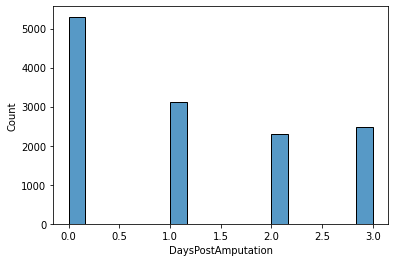

In [6]:
import seaborn as sns
sns.histplot(adata.obs['DaysPostAmputation'])

Selecting timepoint 0 (Day of amputation).

In [7]:
adata = adata[adata.obs['DaysPostAmputation'] == 0] # Subset on the time point 0
adata.layers['counts'] = adata.X.copy() # Copy the raw counts in a different layer

In [8]:
hvg_adata = sc.pp.log1p(adata, copy=True) # Log-normalize the data
sc.pp.highly_variable_genes(hvg_adata, n_top_genes=2000) # Select highly variable genes


/Users/xyc/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:218: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


In [9]:
# Exercise 3 2 normalize per row
sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)

In [10]:
# Exercise 3 3a

sc.pp.highly_variable_genes(hvg_adata, n_top_genes=10)
variable_genes = hvg_adata.var['highly_variable']
top_10_variable = hvg_adata.var[variable_genes].index[:10]
print("Top 10 most variable genes:", top_10_variable)

# Exercise 3 3b
mean_genes = hvg_adata.X.mean(axis=0).A1  
top_10_mean = hvg_adata.var_names[mean_genes.argsort()[-10:]]
print("Top 10 genes with highest mean:", top_10_mean)

# Exercise 3 3c
informative_genes = hvg_adata.var['dispersions_norm'].argsort()[-10:]
top_10_informative = hvg_adata.var_names[informative_genes]
print("Top 10 most informative genes:", top_10_informative)
# Exercise 3 3d
import numpy as np
random_genes = np.random.choice(hvg_adata.var_names, 10, replace=False)
print("10 random genes:", random_genes)

Top 10 most variable genes: Index(['tyrp1.L', 'Xelaev18018852m.g', 'tnni1.2.S', 'tnni2.S',
       'loc100496565.S', 'otog.S', 'Xelaev18039168m.g', 'ctgfl.L',
       'Xelaev18045308m.g', 'Xelaev18047609m.g'],
      dtype='object')
Top 10 genes with highest mean: Index(['rpl23.S', 'Xelaev18003966m.g', 'zc3h10.S', 'Xelaev18045098m.g',
       'rplp1.L', 'Xelaev18000107m.g', 'rps20.L', 'hbd.L', 'Xelaev18045099m.g',
       'hbd.S'],
      dtype='object')
Top 10 most informative genes: Index(['Xetrov90026938m.S', 'slc39a12.S', 'snx15.S', 'Xetrov90026938m.S',
       'Xetrov90026938m.S', 'Xetrov90026938m.S', 'Xelaev18040372m.g',
       'Xetrov90026938m.S', 'barhl1.L', 'rbms2.S'],
      dtype='object')
10 random genes: ['Xelaev18006621m.g' 'Xetrov90003447m.S' 'cd40lg.S' 'dnajb9.S' 'mrpl38.L'
 'vwa9.S' 'prcc.S' 'Xelaev18044113m.g' 'ruvbl1.S' 'Xelaev18010133m.g']


In [11]:
adata.X

<5302x31535 sparse matrix of type '<class 'numpy.float32'>'
	with 10426027 stored elements in Compressed Sparse Row format>

In [12]:
from sklearn.cluster import KMeans
# Exercise 3 4b
kmeans = KMeans(n_clusters=5)
hvg_adata.obs['kmeans_3a'] = kmeans.fit_predict(hvg_adata[:, top_10_variable].X)
hvg_adata.obs['kmeans_3b'] = kmeans.fit_predict(hvg_adata[:, top_10_mean].X)
hvg_adata.obs['kmeans_3c'] = kmeans.fit_predict(hvg_adata[:, top_10_informative].X)
hvg_adata.obs['kmeans_3d'] = kmeans.fit_predict(hvg_adata[:, random_genes].X)

In [14]:
sc.tl.pca(hvg_adata)

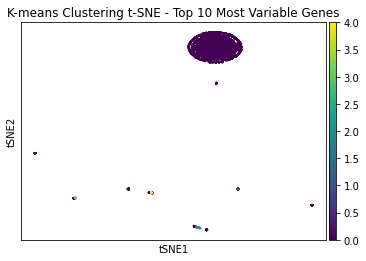

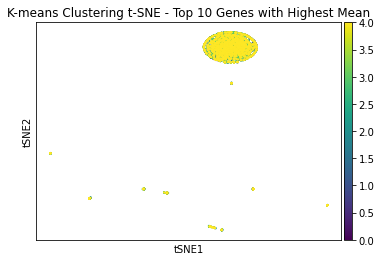

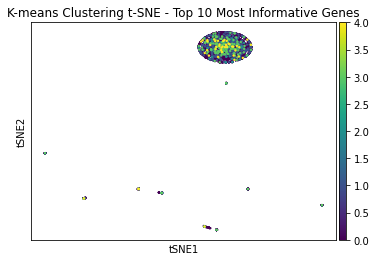

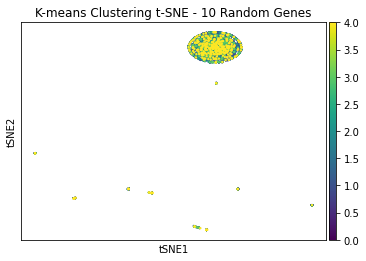

In [15]:
# Run t-SNE on the reduced PCA data
sc.tl.tsne(hvg_adata, use_rep='X_pca')

# Plot t-SNE results for each K-means clustering result
sc.pl.tsne(hvg_adata, color='kmeans_3a', title="K-means Clustering t-SNE - Top 10 Most Variable Genes")
sc.pl.tsne(hvg_adata, color='kmeans_3b', title="K-means Clustering t-SNE - Top 10 Genes with Highest Mean")
sc.pl.tsne(hvg_adata, color='kmeans_3c', title="K-means Clustering t-SNE - Top 10 Most Informative Genes")
sc.pl.tsne(hvg_adata, color='kmeans_3d', title="K-means Clustering t-SNE - 10 Random Genes")


In [16]:
print(sc.pl.pca_variance_ratio)

<function pca_variance_ratio at 0x7f8b78a8bca0>


In [17]:
import numpy as np

explained_variance_ratio = hvg_adata.uns['pca']['variance_ratio']

cumulative_variance = np.cumsum(explained_variance_ratio)

n_pcs_90_var = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of PCs explaining at least 90% of the variance: {n_pcs_90_var}")

n_pcs_95_var = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of PCs explaining at least 95% of the variance: {n_pcs_95_var}")


Number of PCs explaining at least 90% of the variance: 6
Number of PCs explaining at least 95% of the variance: 8


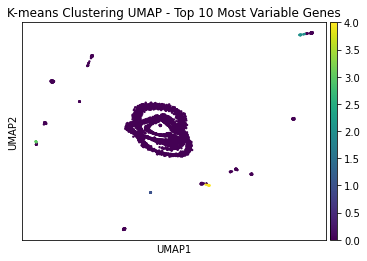

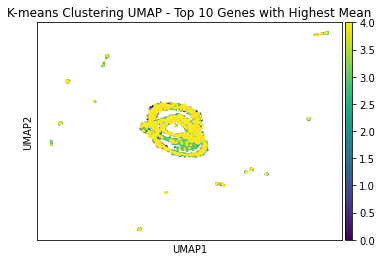

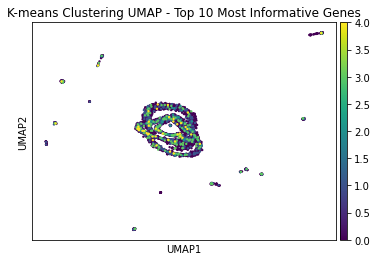

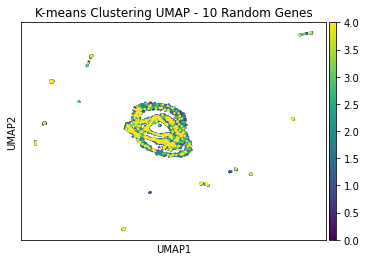

In [18]:
# Run UMAP on the reduced PCA data
sc.pp.neighbors(hvg_adata, use_rep='X_pca', n_pcs=8) 
sc.tl.umap(hvg_adata)

# Plot UMAP results for each K-means clustering result
sc.pl.umap(hvg_adata, color='kmeans_3a', title="K-means Clustering UMAP - Top 10 Most Variable Genes")
sc.pl.umap(hvg_adata, color='kmeans_3b', title="K-means Clustering UMAP - Top 10 Genes with Highest Mean")
sc.pl.umap(hvg_adata, color='kmeans_3c', title="K-means Clustering UMAP - Top 10 Most Informative Genes")
sc.pl.umap(hvg_adata, color='kmeans_3d', title="K-means Clustering UMAP - 10 Random Genes")


In [19]:
# list all diff condition
unique_conditions = adata.obs['Condition'].unique()
print(unique_conditions)

['ST40_0', 'ST46_0']
Categories (2, object): ['ST40_0', 'ST46_0']


## PCA whitening for Leiden clustering



/Users/xyc/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


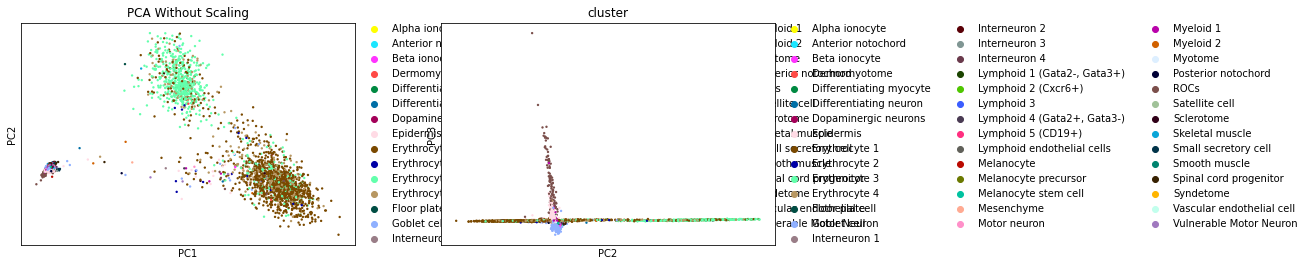

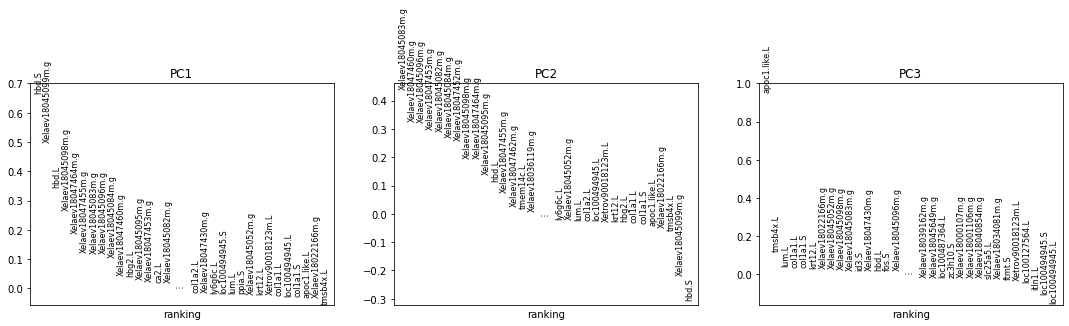

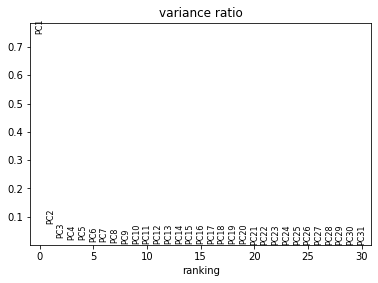

/Users/xyc/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


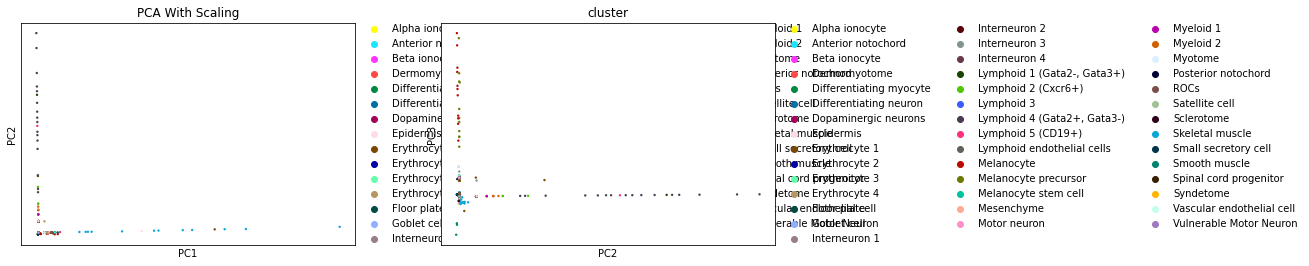

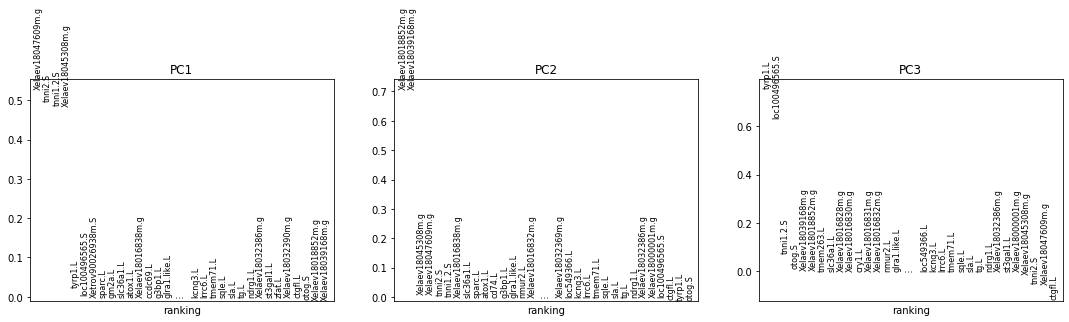

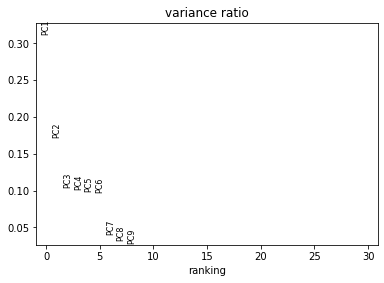

In [20]:
sc.pp.scale(hvg_adata) # Scale data

# Do PCA on the highly variable genes data - you might need to lognormalize to select HVG
sc.tl.pca(hvg_adata)
# sc.pp.pca(hvg_adata)


# 2.PCA without Scaling
sc.tl.pca(adata, svd_solver='arpack')  
sc.pl.pca_overview(adata, color='cluster', components=['1,2', '2,3'], title="PCA Without Scaling")

# 3.PCA After Scaling
sc.tl.pca(hvg_adata, svd_solver='arpack')
sc.pl.pca_overview(hvg_adata, color='cluster', components=['1,2', '2,3'], title="PCA With Scaling")



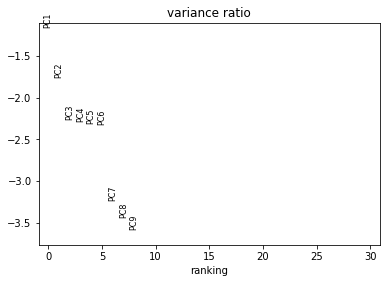

In [21]:
sc.pl.pca_variance_ratio(hvg_adata, log=True)

In [22]:
#sc.pp.scale(hvg_adata) # Scale data

# Do PCA on the highly variable genes data - you might need to lognormalize to select HVG
#sc.tl.pca(hvg_adata)
# sc.pp.pca(hvg_adata)

#sc.pl.pca_overview(hvg_adata, color='cluster', components= ['1,2', '2,3']) # Plot all diagnostics including PC1 against PC2 and PC2 against PC3
#sc.pl.pca_variance_ratio(hvg_adata, log=True) # Plot the variance ratio

In [23]:
# Whitening step - create neighbors graph based on PCA
sc.pp.neighbors(hvg_adata, n_pcs=7) # Create neighbors graph - n_pcs takes the number of principal components from PCA you keep for this step
sc.tl.leiden(hvg_adata, resolution=0.5)  # Apply Leiden clustering, you can adjust the resolution parameter


/Users/xyc/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


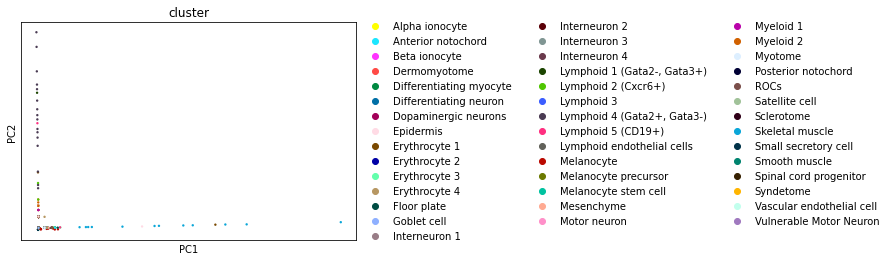

In [24]:
#sc.pl.pca(hvg_adata, color=['leiden']) # Plotting PC1/PC2 with colors from Leiden labels
sc.pl.pca(hvg_adata, color=['cluster']) # Plotting PC1/PC2 with colors from original paper cluster

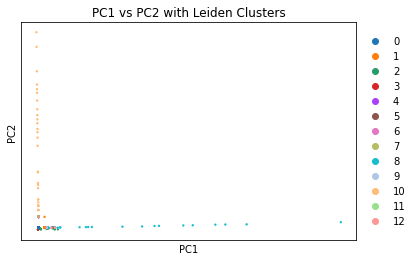

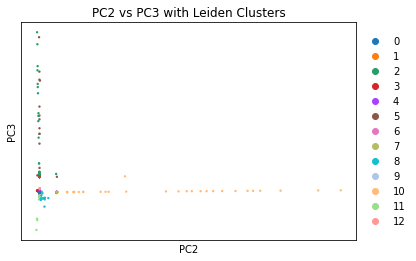

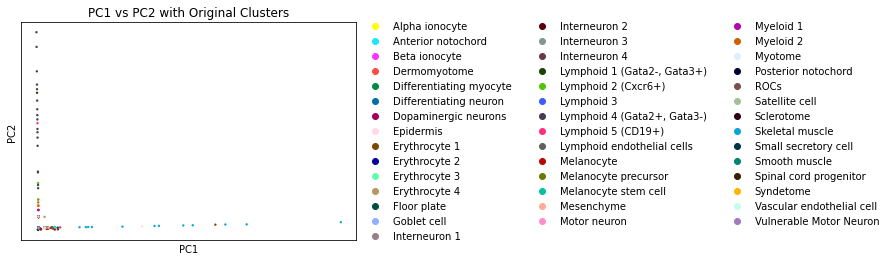

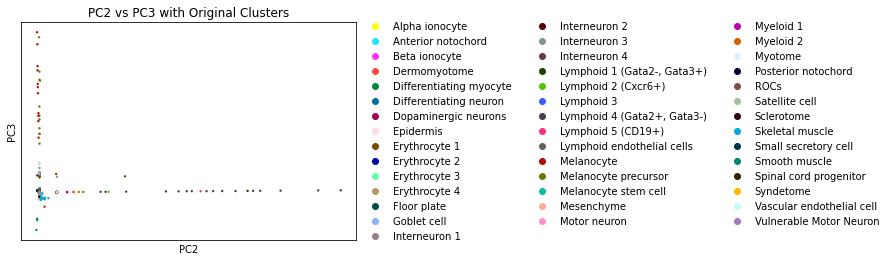

In [25]:
sc.pl.pca(hvg_adata, color='leiden', components=['1,2'], title="PC1 vs PC2 with Leiden Clusters")

sc.pl.pca(hvg_adata, color='leiden', components=['2,3'], title="PC2 vs PC3 with Leiden Clusters")

sc.pl.pca(hvg_adata, color='cluster', components=['1,2'], title="PC1 vs PC2 with Original Clusters")
sc.pl.pca(hvg_adata, color='cluster', components=['2,3'], title="PC2 vs PC3 with Original Clusters")

/Users/xyc/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


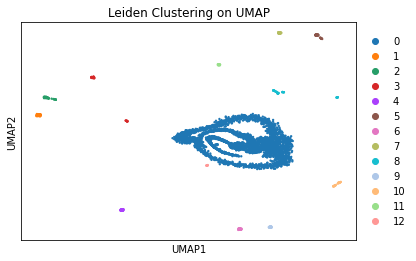

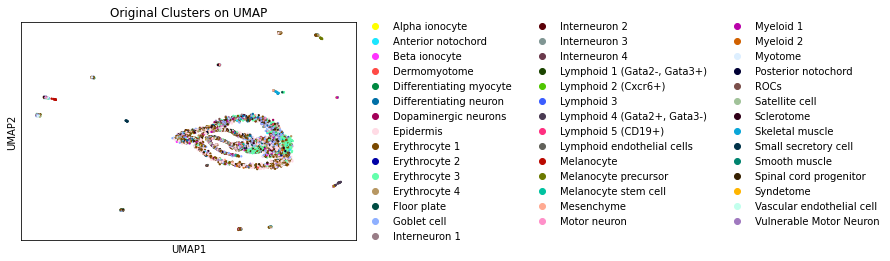

/Users/xyc/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


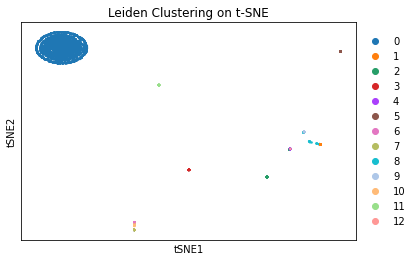

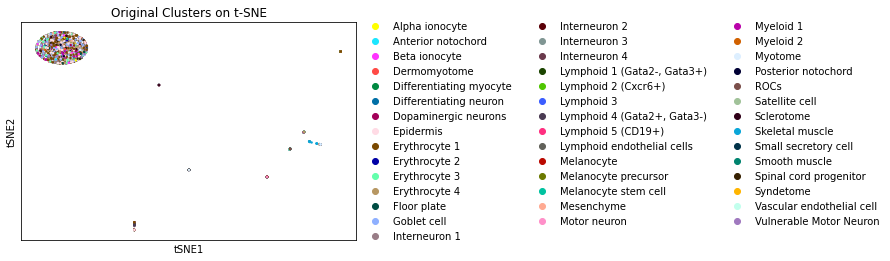

In [26]:

# 5a. UMAP Visualization of Leiden Clusters
sc.tl.umap(hvg_adata)  # Compute UMAP coordinates
sc.pl.umap(hvg_adata, color='leiden', title="Leiden Clustering on UMAP")  # Plot UMAP with Leiden clusters

# 5b. UMAP Visualization of Original Clusters 
sc.pl.umap(hvg_adata, color='cluster', title="Original Clusters on UMAP")  # Plot UMAP with original clusters

# 5c. t-SNE Visualization of Leiden Clusters
sc.tl.tsne(hvg_adata, use_rep='X_pca')  # Compute t-SNE using PCA-reduced data
sc.pl.tsne(hvg_adata, color='leiden', title="Leiden Clustering on t-SNE")  # Plot t-SNE with Leiden clusters

# 5d. t-SNE Visualization of Original Clusters 
sc.pl.tsne(hvg_adata, color='cluster', title="Original Clusters on t-SNE")  # Plot t-SNE with original clusters


In [27]:
!pip install louvain

In [28]:
# Apply Lovvain clustering
sc.tl.louvain(hvg_adata, resolution=0.5)  

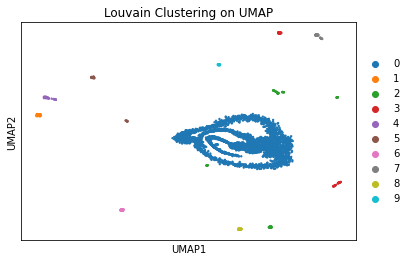

/Users/xyc/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


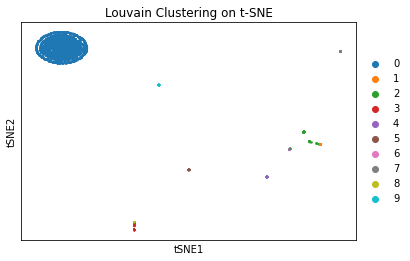

In [29]:
# UMAP visualization for Louvain clusters
sc.pl.umap(hvg_adata, color='louvain', title="Louvain Clustering on UMAP")

# t-SNE visualization for Louvain clusters
sc.tl.tsne(hvg_adata, use_rep='X_pca')
sc.pl.tsne(hvg_adata, color='louvain', title="Louvain Clustering on t-SNE")


In [30]:
from sklearn.metrics import silhouette_score

#  silhouette score for Leiden clusters
silhouette_leiden = silhouette_score(hvg_adata.obsm['X_umap'], hvg_adata.obs['leiden'])
print(f"Silhouette Score for Leiden: {silhouette_leiden}")

#  silhouette score for Louvain clusters
silhouette_louvain = silhouette_score(hvg_adata.obsm['X_umap'], hvg_adata.obs['louvain'])
print(f"Silhouette Score for Louvain: {silhouette_louvain}")


Silhouette Score for Leiden: 0.3449666500091553
Silhouette Score for Louvain: 0.6603932976722717


In [31]:
from sklearn.metrics import adjusted_rand_score

#  ARI between Leiden and Louvain clusters
ari = adjusted_rand_score(hvg_adata.obs['leiden'], hvg_adata.obs['louvain'])
print(f"Adjusted Rand Index between Leiden and Louvain: {ari}")

Adjusted Rand Index between Leiden and Louvain: 0.9990933146790516


In [32]:
from sklearn.metrics import normalized_mutual_info_score

#  NMI between Leiden and Louvain clusters
nmi = normalized_mutual_info_score(hvg_adata.obs['leiden'], hvg_adata.obs['louvain'])
print(f"Normalized Mutual Information between Leiden and Louvain: {nmi}")


Normalized Mutual Information between Leiden and Louvain: 0.9768511898124971


# Marker Selection and Gene Analysis:


/Users/xyc/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


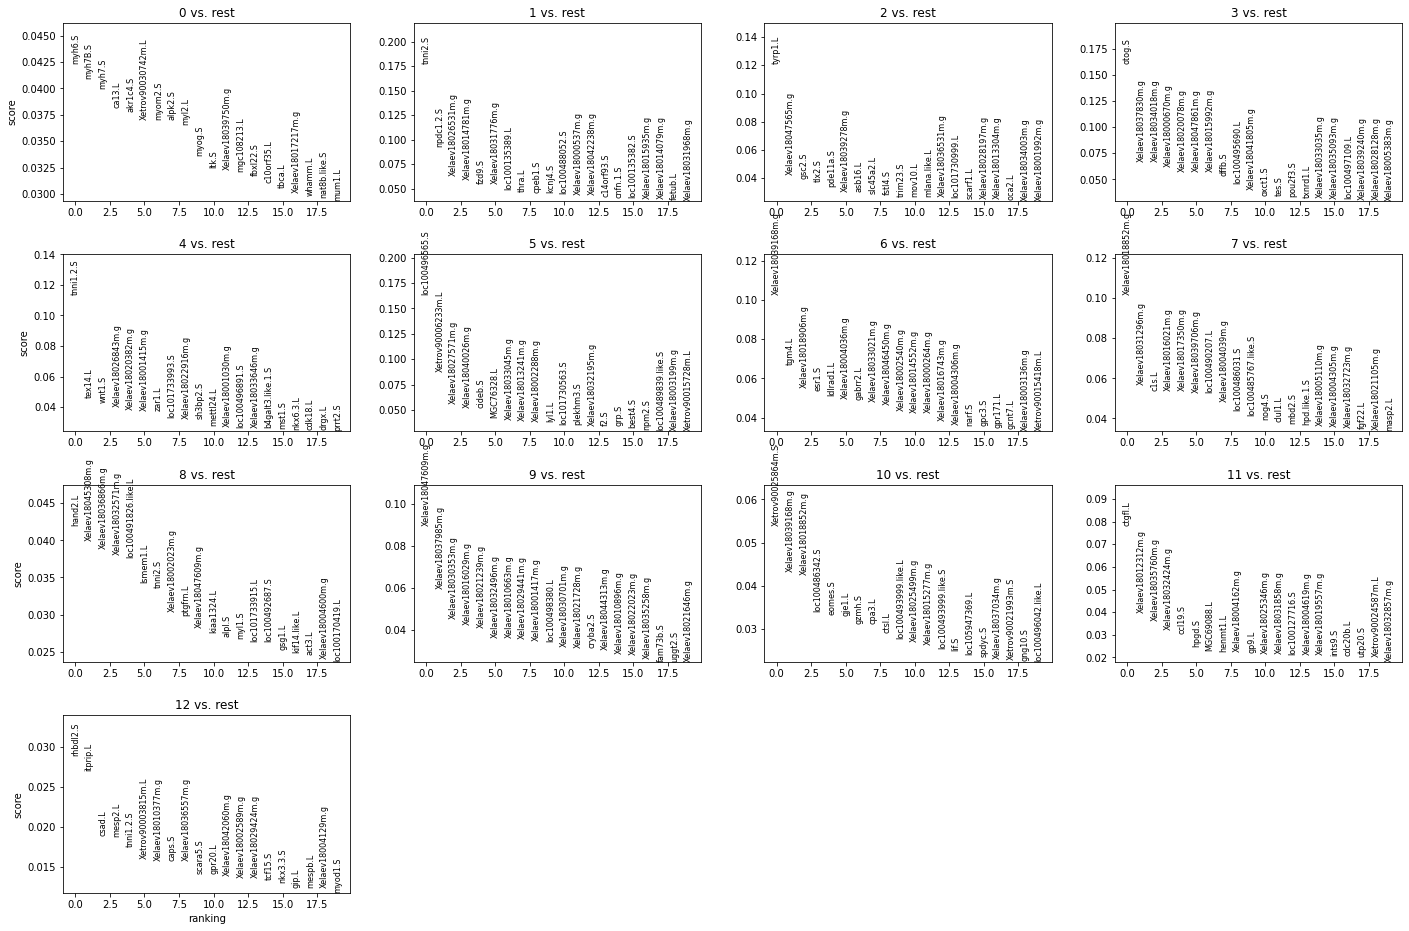

In [33]:
#  logistic regression to identify marker genes
sc.tl.rank_genes_groups(hvg_adata, groupby='leiden', method='logreg')  

# top markers for each cluster identified by logistic regression
sc.pl.rank_genes_groups(hvg_adata, n_genes=20, sharey=False, title="Logistic Regression Marker Genes")


/Users/xyc/opt/anaconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


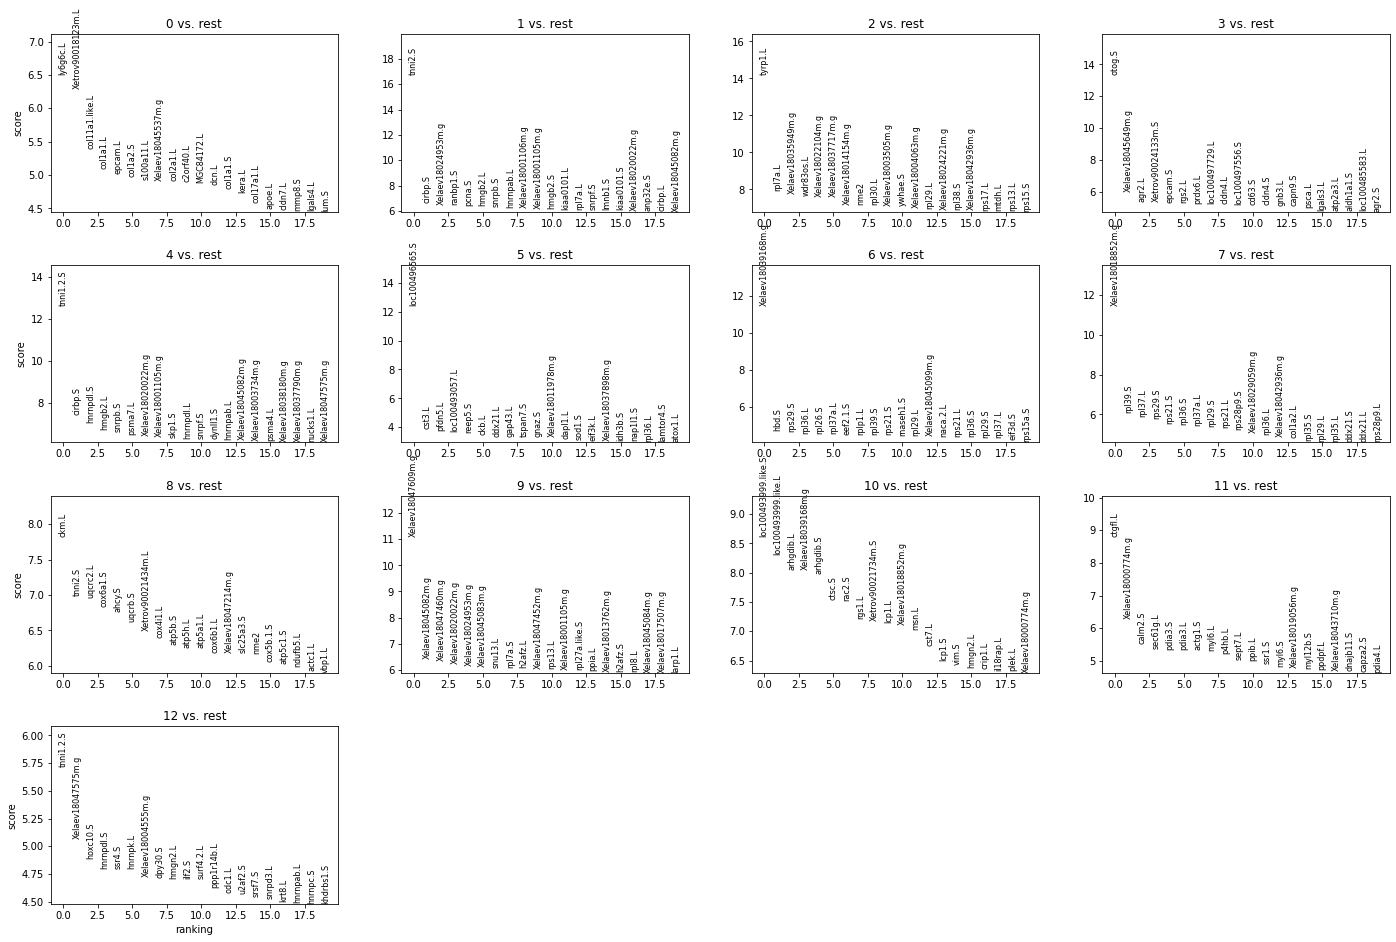

In [34]:
#  Wilcoxon test to identify marker genes
sc.tl.rank_genes_groups(hvg_adata, groupby='leiden', method='wilcoxon')

#  top markers for each cluster identified by Wilcoxon test
sc.pl.rank_genes_groups(hvg_adata, n_genes=20, sharey=False, title="Wilcoxon Marker Genes")


In [35]:
logreg_genes = hvg_adata.uns['rank_genes_groups']['names']
wilcoxon_genes = hvg_adata.uns['rank_genes_groups']['names']

In [38]:
top_20_logreg_genes = [gene for gene in logreg_genes[:20] if gene is not None]
top_20_wilcoxon_genes = [gene for gene in wilcoxon_genes[:20] if gene is not None]

logreg_genes_flat = set(gene for sublist in top_20_logreg_genes for gene in sublist)
wilcoxon_genes_flat = set(gene for sublist in top_20_wilcoxon_genes for gene in sublist)

overlap_genes = logreg_genes_flat.intersection(wilcoxon_genes_flat)
num_overlap_genes = len(overlap_genes)

num_unique_logreg_genes = logreg_genes_flat - overlap_genes
num_unique_wilcoxon_genes = wilcoxon_genes_flat - overlap_genes


print("Top 20 Overlapping Genes:", overlap_genes)
print(f"Number of overlapping genes in top 20: {num_overlap_genes}")
print(f"Number of unique genes in top 20 for logistic regression: {num_unique_logreg_genes}")
print(f"Number of unique genes in top 20 for Wilcoxon test: {num_unique_wilcoxon_genes}")



Top 20 Overlapping Genes: {'kiaa0101.L', 'rpl8.L', 'col2a1.L', 'rpl7a.L', 'vim.S', 'tnni2.S', 'sod1.S', 'rnaseh1.S', 'atp5a1.L', 'Xelaev18037898m.g', 'loc100497729.L', 'Xelaev18045537m.g', 'ckb.L', 'sec61g.L', 'lmnb1.S', 'aldh1a1.S', 'Xelaev18004063m.g', 'Xelaev18017507m.g', 'sept7.L', 'rps21.L', 'uqcrc2.L', 'gap43.L', 'cox6b1.L', 'Xelaev18047575m.g', 'ddx21.S', 'tnni1.2.S', 'ssr4.S', 'eif3d.S', 'capza2.S', 'gnb3.L', 'rplp1.L', 'srsf7.S', 'pfdn5.L', 'Xelaev18047452m.g', 'ckm.L', 'cox6a1.S', 'Xelaev18004555m.g', 'rgs1.L', 'Xelaev18045649m.g', 'rpl37a.L', 'Xelaev18029059m.g', 'Xelaev18003734m.g', 'Xelaev18013762m.g', 'myl6.L', 'lgals3.L', 'cldn4.S', 'nucks1.L', 'slc25a3.S', 'hbd.S', 'atp5b.S', 'ssr1.S', 'col17a1.L', 'cox5b.1.S', 'lcp1.L', 'rpl29.S', 'atp5h.L', 'cst7.L', 'tyrp1.L', 'loc100497556.S', 'cldn7.L', 'Xelaev18039168m.g', 'Xelaev18047460m.g', 'gnaz.S', 'khdrbs1.S', 'surf4.2.L', 'ly6g6c.L', 'idh3b.S', 'agr2.L', 'Xelaev18000774m.g', 'actg1.S', 'ywhae.S', 'dapl1.L', 'ppp1r14b.L', 'l

In [39]:
import pandas as pd

supp_table = pd.read_csv('MarkerList.csv', header=None, names=['gene_name'])

In [40]:
# Convert the gene names in the supplementary table to a set for easy comparison
supp_genes = set(supp_table['gene_name'].dropna())


identified_genes = logreg_genes_flat.union(wilcoxon_genes_flat)

overlap_with_supp = identified_genes.intersection(supp_genes)
unique_to_identified = identified_genes - supp_genes
unique_to_supp = supp_genes - identified_genes

print(f"Number of overlapping genes: {len(overlap_with_supp)}")
print("Overlapping Genes:", overlap_with_supp)
print(f"Number of unique genes in identified markers: {len(unique_to_identified)}")
print(f"Number of unique genes in Supplementary Table 3: {len(unique_to_supp)}")


Number of overlapping genes: 1
Overlapping Genes: {'pcna.S'}
Number of unique genes in identified markers: 221
Number of unique genes in Supplementary Table 3: 83


In [42]:
hvg_adata.obs['louvain'] = hvg_adata.obs['louvain']

In [43]:
kmeans = KMeans(n_clusters=5)  
hvg_adata.obs['kmeans'] = kmeans.fit_predict(hvg_adata.obsm['X_pca'])

/Users/xyc/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


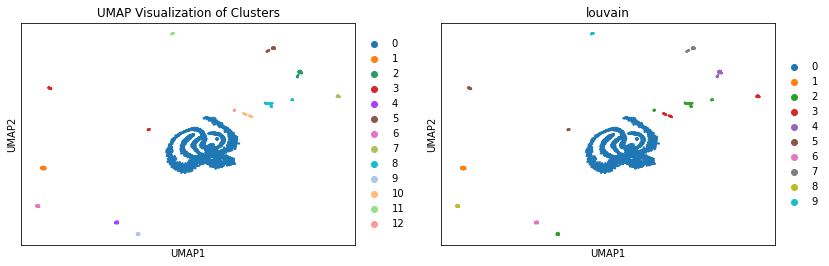

In [44]:
sc.tl.umap(hvg_adata)
sc.pl.umap(hvg_adata, color=['leiden', 'louvain'], title="UMAP Visualization of Clusters")

/Users/xyc/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


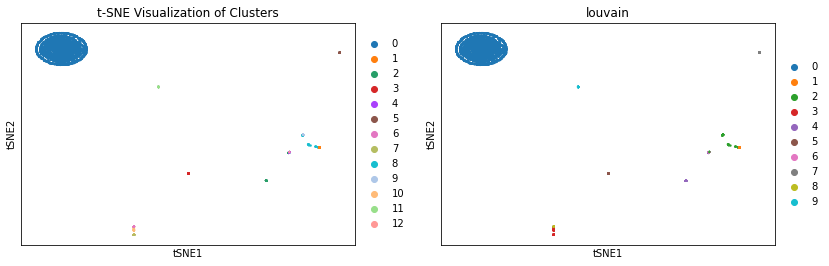

In [45]:
sc.tl.tsne(hvg_adata, use_rep='X_pca')
sc.pl.tsne(hvg_adata, color=['leiden', 'louvain'], title="t-SNE Visualization of Clusters")

In [46]:
ari_score = adjusted_rand_score(hvg_adata.obs['leiden'], hvg_adata.obs['louvain'])
print("Adjusted Rand Index between Leiden and Louvain clusters:", ari_score)

Adjusted Rand Index between Leiden and Louvain clusters: 0.9990933146790516


In [47]:

silhouette_leiden = silhouette_score(hvg_adata.obsm['X_umap'], hvg_adata.obs['leiden'])
silhouette_louvain = silhouette_score(hvg_adata.obsm['X_umap'], hvg_adata.obs['louvain'])
print("Silhouette Score for Leiden:", silhouette_leiden)
print("Silhouette Score for Louvain:", silhouette_louvain)


Silhouette Score for Leiden: 0.55099535
Silhouette Score for Louvain: 0.701619
